In [2]:
import numpy as np
from scipy.stats import norm, ncx2, gamma
import matplotlib.pyplot as plt
import fixed_income_derivatives as fid
from scipy.optimize import minimize

In the SABR model, the forward rate denoted $F_t$, typically a forward par swap rate, follows a stochastic process with stochastic volatility $\sigma_t$. The joint dynamics of $F_t$ and $\sigma_t$
$$
\begin{aligned}
d F_t & =\sigma_t^\beta F_t d W_t^{(1)}, & & F(0)=F_0 \\
d \sigma_t & =v \sigma_t d W_t^{(2)}, & & \sigma(0)=\sigma_0 \\
d W_t^{(1)} d W_t^{(2)} & =\rho & &
\end{aligned}
$$
where $\sigma_0>0,0<\beta \leq 1, v>0$ and $-1<\rho<1$ are parameters of the model. Zero coupon bond prices observed from market data are given in the below table.

\begin{array}{|c|c|c|c|c|c|c|c|}
\hline T & 0.50 & 1.00 & 1.50 & 2.00 & 2.50 & 3.00 & 3.50 \\
\hline p(0, T) & 0.98429046 & 0.96633686 & 0.94690318 & 0.92655036 & 0.90568659 & 0.88460647 & 0.86352084 \\
\hline \hline T & 4.00 & 4.50 & 5.00 & 5.50 & 6.00 & 6.50 & 7.00 \\
\hline p(0, T) & 0.84257919 & 0.82188628 & 0.80151436 & 0.78151217 & 0.76191149 & 0.74273188 & 0.72398415 \\
\hline
\end{array}

If you want to buy swaption at strike offset of -300 and you want to shop notional of 100m it will cost you 12M. Offset is 3 pct.point below the 2y5y par swap rate.

\begin{aligned}
&\text { Table 2: 2Y5Y Swaption prices }\\
&\begin{array}{|c|c|c|c|c|c|c|c|}
\hline K_{\text {offset }}(b p) & -300 & -250 & -200 & -150 & -100 & -50 & \text { ATMF } \\
\hline \Pi_{\text {swaption }} & **0.12301549** & 0.10339456 & 0.08421278 & 0.06567338 & 0.04843543 & 0.03300976 & 0.02048677 \\
\hline \hline K_{\text {offset }}(b p) & 50 & 100 & 150 & 200 & 250 & 300 & - \\
\hline \Pi_{\text {swaption }} & 0.01173834 & 0.00648577 & 0.00361682 & 0.00215934 & 0.00137503 & 0.00093634 & - \\
\hline
\end{array}
\end{aligned}

$$
R_n^N(t) = (P_n-P_N) / S_n^N(t) = (P_n-P_N)/(sum_i=n+1 to Na_i P(t,T_I)

In [ ]:
alpha = 0.5
T_max = 7
idx_exer, idx_set = 4, 14
K_swaption_offset = [-300,-250,-200,-150,-100,-50,0,50,100,150,200,250,300]
N_swaption = len(K_swaption_offset)
M = int(round(T_max/alpha)+1)
T = np.array([i*alpha for i in range(0,M)])
p = np.array([1, 0.98429046, 0.96633686, 0.94690318, 0.92655036, 0.90568659, 
price_market = np.array([0.12301549, 0.10339456])

In [ ]:
S_swap = 0
for i in range(idx_exer+1,idx_set + 1):
    S_swap += alpha*p[i]
R_swap = (p[idx_exer] - p[idx_set])/S_swap
print(f'accrual factor: {S_swap}, 2y5y par swap rate: {R_swap}')

we get a accrual factor of 4 which is reasonable for a 5y maturtiy, this is also a sanity check: should be close to maturity!

ii) to compute Black IV we use function 

In [ ]:
iv, K = np.zeros([N_swaption]), np.zeros([N_swaption])
for i in range(0,N_swaption):
    K[i] = R_swap + K_swaption_offset[i]/10000
    iv[i] = fid.black_swaption_iv(price_swaption[i],T[idx_exer],K[i],S_swap,R_swap,type = "call", iv0 = 0.2, max_iter = 1000, prec = 1.0e-12)
print(f"Implied volatilities deduced from market prices:")
print(iv) # i.e. the choice of sigma reproducing price showed into  C in the black_swaption_iv 

In [ ]:
remember to adjust iv0, initial guess of iv, if we get NaN

iii) PLotting IV, we see that the market is not using Blacks formula since we see a smirk and not flat, i.e. not independent of strike prices! Thus, motivating our use of sabr model.

The fitted values look close to market implied volatilities.

NameError: name 'K_swaption_offset' is not defined

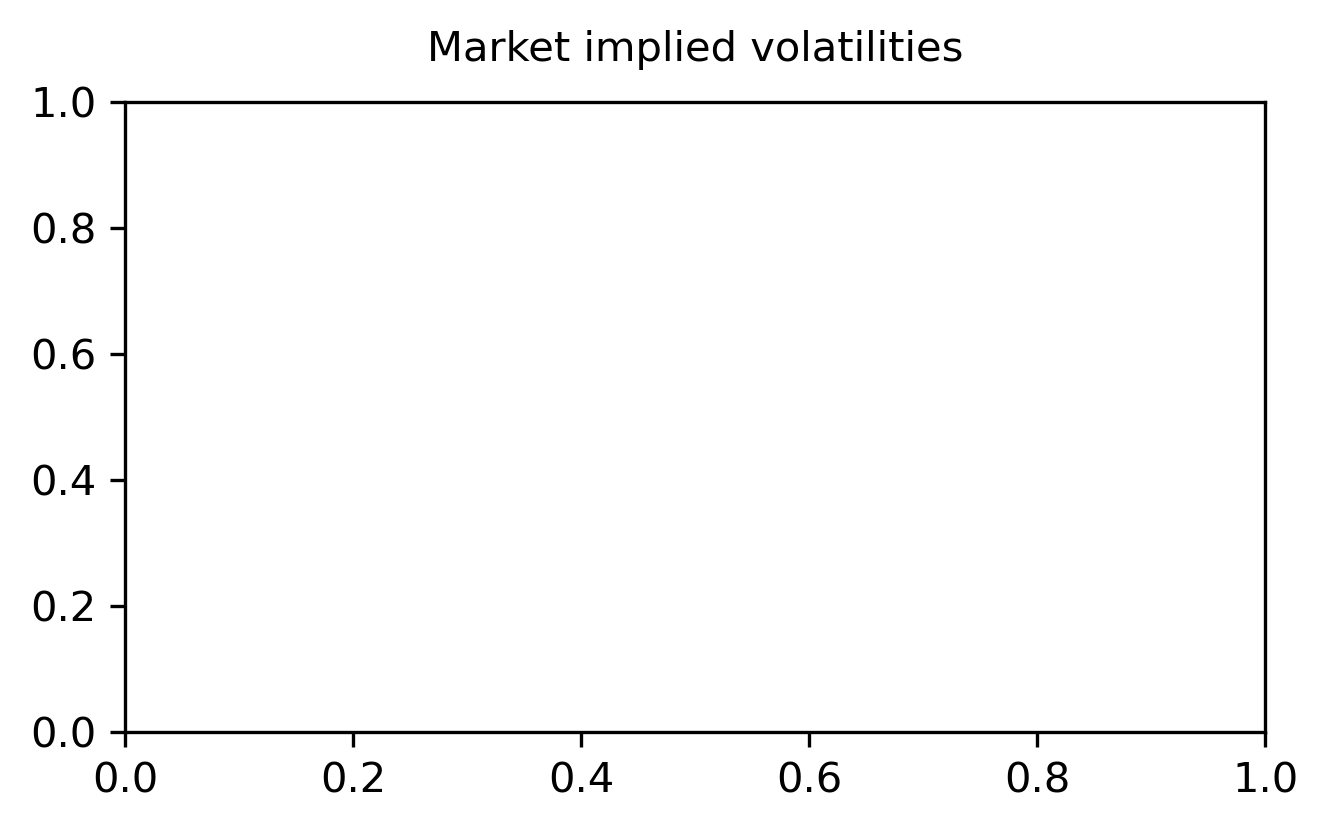

In [3]:
# Plot of market implied volatilities
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Market implied volatilities", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])

xticks = K_swaption_offset
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.02,xticks[-1]+0.02])
plt.xlabel(f"Strike offset",fontsize = 7)
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.set_yticklabels([0,0.1,0.2,0.3,0.4],fontsize = 6)
ax.set_ylim([0,0.408])
# plt.ylabel(f"Delta",fontsize = 6)
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
# plt.minorticks_on()
# plt.grid(which='minor', color='grey', linestyle='--')
# ax.set_ylabel(f"",fontsize = 6)
p1 = ax.scatter(K_swaption_offset, iv, s = 3, color = 'black', marker = ".",label="IV market")
# p2 = ax.scatter(T[1:], L[1:], s = 3, color = 'red', marker = ".",label="forward rates")
plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)

# plt.show()

c)

For a 2y5y forward par swap rate, the longest we can simulate is 2y as it becomes a spot par swap rate more over the time of exercise has passed! e.g. simulating for 3 years will be a problem if 2y5y fowrad swap rate is fixed.

for seed 4 it sits around 6 %, but for seed else volatility blows up. Unlike, Vasicek (Uhlenbeck-Ornstein SDE) and CIR. For last one it is zero. 

d)

$$
\pi(t)=E^Q\left[e^{-\int_0^T r_s d s} \chi(x)\right]=p(t, T) E^{Q^T}[\chi(x)]=p\left(t, T_n\right) E^{Q^T n}\left[1_{F_{T_n}>K}\right]=p(t, T) Q^{T_n}\left(F_{T_n}>K\right)
$$

Where $T_n$ is time of exercise. So we can simulate the probability that the underlying $F$ at exercise is greater than strike $\mathrm{K}$ (atm forward rate + 75 bps). Where estimated probability is simply fraction of times where F_T_n is above K using simulation and then multply by the time zero price of 1 unit of currency delivered at exercise time.

d)

We don't have what investor wants but we can synthetize!

This will not protect against huge market sell of due to interest rates rising, because the payoff is capped.

e)

We can hedge in SABR against parameter changes, which can be due to rho, sigma and spot curve:

say you have shift in market from right to left tail, i.e. rho changing, which would not be good if invested in right tail swaption. So we can ask what is our exposure to rho. Or what happens if sigma falls?

If sigma falls, the payoff falls as well. If you sit on a call option, you would want variation (a lot of volatility, i.e. a change that underlying blows up), resulting in a lot of money! But it can at worse case expire worthless (deep out-themoney).

You can be afected by change in spot curve which affects the underlying! Say fall, The value of position falls as chance of finishing in the money goes down!